In [34]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [47]:
board_size = 30
device = torch.device('cuda')
batch_size = 32

In [74]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2),
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    def forward(self, x):
        return self.layers(x)

In [75]:
mlp = MLP()
# mlp = torch.load("model")
# mlp.train()
losses = []
train = []
running_loss = 1
mlp.to(device)

MLP(
  (layers): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (16): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [83]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-5)

In [107]:
while True:
    dataset, moves, length = game_sim()
    
    for sample in dataset:
        rand = int(np.random.rand() * len(train))
        sample.append(length/900)
        train.append(sample)
        if len(train) > 10000:
            train.remove(train[rand])
    
    batch = torch.zeros(1, 1, 30, 30, device=device)
    labels = torch.zeros(batch_size, 1, device=device)
    
    for i in range(batch_size):
        rand = int(np.random.rand() * len(train))
        sample = train[rand][:len(train[rand]) - 1]
        labels[i] = train[rand][len(train[rand]) - 1:][0]
        board = torch.zeros(board_size, board_size, device=device)
        for number, tupl in enumerate(sample):
            board[tupl] = ((number + 1)/len(sample))
        batch = torch.cat([batch, board.view(1, 1, 30, 30)], dim=0)
        
    batch = torch.cat((batch[:0], batch[0+1:])) # remove first row
    optimizer.zero_grad()
    outputs = mlp(batch) #(length, moves)
    loss = loss_function(outputs, labels)
    running_loss = (running_loss * 0.9) + (loss.item() * 0.1)
    print(running_loss)
    losses.append(running_loss)
    loss.backward()
    optimizer.step()
        


0.0013583478491304556
0.001309380920079193
0.0012592712665842546
0.0012950354293209231
0.0013494013656129168
0.0013366559546060615
0.0013009984395310806
0.0013270364201021668
0.0013025458255889247
0.0012958013103811948
0.0012845188088670978
0.0013049990398955888
0.0013041635574532343
0.0013147927692874783
0.0012907548925365072
0.0012385339523983804
0.0012610281092307993
0.001259876890022936
0.0012242291671389783
0.0012365718633178871
0.001274111783340037
0.0012442727449360135
0.0012639830522527674
0.001256324463736151
0.0012597973077605375
0.001243271448830683
0.0012239309008001556
0.0012226199434023444
0.0012586787587766063
0.0012446221417290759
0.0012088733504394703
0.0011997934092369685
0.0011896867326382109
0.0011609276403322794
0.0011429905945958177
0.0011545537042157185
0.001171349736622989
0.0011395428166437328
0.001141304934138642
0.0011205283238552538
0.0011115668818075235
0.00111146167950053
0.001116018872193715
0.001103990781589348
0.0011007739980263998
0.001107834346971824


0.001167713758410541
0.0012181302795923005
0.001198499112344496
0.0011728853785023502
0.0011855940121136973
0.0012467700889160814
0.001203837939950876
0.0011963643421409004
0.0012129122161390609
0.0011978107553703094
0.001233299837680832
0.001185170030710556
0.001193665764269195
0.0012148315966832297
0.0012452880572787813
0.0012015652451898358
0.0012120961884247395
0.001185214284342122
0.0012294731407895016
0.0012184706371978814
0.0012415566677486207
0.00121230289938393
0.0012515891401865431
0.0012513820972798778
0.0012594703618332905
0.0012548727479110803
0.00121231982405944
0.001295617361777693
0.0013188061717125804
0.001291516793319407
0.0012722798973758428
0.0012917158183475802
0.0013436832991372467
0.001402394704841607
0.001391859889039874
0.0013862087702463388
0.0013706782251300205
0.0013657433644974342
0.00134561280177928
0.0013496462789012223
0.0013363235318437127
0.001297258743906758
0.0012475933627170996
0.0012294852227016696
0.0012007577554735012
0.0012103917918073357
0.0012

0.001301121099959632
0.0013475069811604802
0.0013336993227001178
0.0013353734687727226
0.001354392068156141
0.00132032390097696
0.0013537475088007903
0.0013238367740080646
0.001320925374665787
0.001305520617445347
0.001297028786633942
0.0012884296822610797
0.0012902983263266058
0.0013161874847232077
0.0013215626781018471
0.0013157161846420373
0.0013178540243464296
0.0013168165790668953
0.001278366341192886
0.0013303520425589663
0.0013464234800687537
0.0013843327369810138
0.0013779785830769832
0.0013500744369844106
0.001332435046465204
0.0013019548854211025
0.001307729745371257
0.0013174417171483768
0.0013232120849621773
0.0013445233035660519
0.001348216751537627
0.0013474917901205178
0.001347329514840736
0.0013193327311563437
0.0012936345859367799
0.001322571087073459
0.0013913108057002786
0.0013649084996778277
0.001322971734063194
0.0013119954378810815
0.0013571530693165027
0.0013693459899030533
0.001416004453596688
0.0014375121303064078
0.0014224687424819872
0.0013981092385221606
0.0

0.001606668962046386
0.0015881570015891325
0.001526386696953529
0.0015224105911372191
0.0015056611807124096
0.0014976620620616922
0.0014717228988449557
0.0014757363818078443
0.0014894836227511649
0.0014775513910873488
0.0014919730863979838
0.0014496380233514053
0.0014305897548792727
0.00139480469284561
0.0013245124337429408
0.0013375183165688458
0.0013406178412767478
0.001362975653318217
0.0013547173283578312
0.00131126577233878
0.0013220057002509287
0.0013575406449225233
0.0013098744630440343
0.001414035815413976
0.0014064495508368472
0.0013687830283041888
0.0013573742256727302
0.0013695627024695115
0.0014085352107032988
0.0013963269299621748
0.0013598543589097589
0.0014223668489038049
0.0014089003878321438
0.0013645189884478918
0.001351773281846947
0.0013513354313153087
0.0013381541788305097
0.001348827567783766
0.001394074145335948
0.001370944729115661
0.0013530949709373082
0.0013453262936561434
0.0013406854449612615
0.0013426994616861092
0.001352707447639848
0.0014470450868368852
0

0.0014414212635326194
0.0014043133514859802
0.0014589267145310517
0.0014732196865497242
0.001431238485080887
0.0014053476014125846
0.0014055069044281695
0.0013578944536715436
0.0013171706856100727
0.0012525345411036732
0.0012754403292284302
0.0012324651707503998
0.0012198625229412738
0.0012667653098432205
0.0012809204449261411
0.0012506847800132798
0.001256350522159085
0.0012584020999463308
0.0013362388773910916
0.0013331106282385634
0.0013410679752033157
0.001333728929909426
0.0013869001814446075
0.0014003973989535473
0.0013821158737219068
0.0013234077031319613
0.0013669463977691776
0.001370086978753857
0.0013409965880636443
0.0013680360607809486
0.0013416830512514707
0.0013669067514246104
0.001397462797967082
0.0013393985021814578
0.0013940405884903557
0.0013965930005480547
0.0014837391993167727
0.0014408440569352564
0.001413303157979529
0.0013811111702979632
0.0013686530822219875
0.0013771971932011033
0.0013508004402852521
0.0013854263916152536
0.0013451671550754744
0.00140889877100

0.0013587439498078903
0.0013695175049958004
0.0013934075962125398
0.0013481239905016845
0.001412770386119833
0.0014143777416618024
0.0013821365614805836
0.0013613932526550488
0.0012944288313001511
0.0013285210583569216
0.001347616163064087
0.0013000679232946437
0.00125527092996431
0.0012325657607602412
0.0012621832707363965
0.0012629874941040816
0.0012126666224074134
0.0011921507389684113
0.0012182607762968175
0.001188227807398644
0.0012548943086707655
0.0012612561262468156
0.0012869050336765937
0.0012708338977370584
0.0012490201337463191
0.0011950502611783771
0.0012328294129002955
0.0012637688100706518
0.0012560936710942668
0.0012734958702363564
0.001240578806686818
0.001247090534900206
0.0012147215500689992
0.0011765230326362653
0.0011396277936518077
0.0011595153815607624
0.0011825181727090834
0.0011526986062154346
0.0012009598860182023
0.0011807275914658
0.0011618333989166223
0.0011490439196519258
0.0011549312972732367
0.0011770782609991416
0.0011919760313447284
0.001182322754761514

0.0012045664449210087
0.0011797286484193164
0.0011736959374518416
0.0011789682554368278
0.0011808392568749876
0.0012183492866111717
0.0012085410898993543
0.001234008816837084
0.0012130809622262226
0.001199142507777003
0.0011976694615397341
0.00114975743970321
0.001168070650117514
0.0011632092803495384
0.0011525659206682972
0.0011267044330432593
0.0010986644362474603
0.0010445276719203702
0.0010547463948834936
0.0010098120883197188
0.0010132157022587002
0.0010489612874796874
0.0011299126856135625
0.0011272493933423427
0.0012545313106284203
0.0012845401782219704
0.0012730873306922702
0.0013050108228921224
0.0012880908382877107
0.0012523675389240142
0.0012350884405955634
0.0012389399027505482
0.0013274547941099673
0.0013140806310946707
0.00131889802901372
0.0013292117419735315
0.0013289154891651025
0.0013039638541174966
0.001343823724365953
0.001397543750462732
0.001407927375442804
0.0013877637752804349
0.0013817098751810065
0.0013357355617490594
0.0013367369534528718
0.001338355336010289

0.0012662172852394588
0.0012653610777948149
0.001273438870460735
0.00123835278136554
0.0012974183022016821
0.0012991273332082812
0.0012453435148397313
0.0012630598390638136
0.0012943389316795145
0.0013131726634113081
0.0012882260906085154
0.0013170551010677023
0.001310158015113366
0.0012882368277650704
0.0012616788480147687
0.0012187432966312738
0.0012045990422194575
0.001235028983096812
0.0011902255198945409
0.0012021406121855802
0.001218548336317166
0.001179059711929805
0.001197100876013917
0.0012542478044618509
0.0012687835309466132
0.0012871595551276571
0.0012468845407959254
0.0012582091596317082
0.0012766218564778677
0.0012872209797236422
0.0013012855918086857
0.0013063704254144988
0.001310766518175414
0.0013041024318499663
0.001325936188429293
0.0013353202047986063
0.0012856089156978374
0.0012459593763415257
0.0012276153304097868
0.001235954935327275
0.00122520963752279
0.0011773681946829794
0.0011514088610100005
0.0011870511486489106
0.0011968134613506672
0.001201617766246737
0.

0.0011807559080383642
0.0011752350159513769
0.001207431909340127
0.0011729401202142272
0.0011257099012932212
0.0012120266653955906
0.0012672705344805952
0.0012524399558782433
0.0012710095466185976
0.0012279562167980703
0.001264342005099365
0.0012707967792113205
0.001309685303344689
0.001320238549105253
0.0013230601097906469
0.0013400477967163776
0.0012992622833178213
0.0012731317813039515
0.0012664116401641691
0.0012649151310326868
0.0012723894692028058
0.0012399955052418553
0.0012359408726870754
0.0012200222735252743
0.0012258821257074266
0.0012506089230994515
0.001229192498679769
0.0012107695741779912
0.001273146004341004
0.001314556879575811
0.0012789193659226705
0.0012425726898417423
0.0011965496137728289
0.0011740475109024342
0.001211071071901485
0.0012450512806544286
0.0012213197022276742
0.0012073101036077104
0.0011763632984396393
0.0012097495620864546
0.0012081317894534393
0.0011945239902624001
0.0012004298449535826
0.001193051373748153
0.0011780838643728224
0.00119473255530090

0.0010413841857737267
0.0010823429605045286
0.0011157221525396437
0.0010783828249951927
0.0010693888807041104
0.0010850893432267895
0.0010873646983312123
0.00105541517523623
0.0010940223339031322
0.0011190894829777047
0.0011560332397041171
0.0012015796410516605
0.00124115961037359
0.001224062205782068
0.0012378423306842437
0.0012483560235947184
0.0012539145107365976
0.00127063893806985
0.0012579378475506692
0.001198666146739312
0.0011637599519828598
0.001125278158752439
0.0011321457805275777
0.0011036600781379514
0.0011046089575050806
0.0011536324891768578
0.0011472527010729329
0.0012590974914423003
0.0012378113096110262
0.0012310576820882175
0.0012621817262034429
0.0012835861793922617
0.0012834728103779764
0.0012980393532874893
0.0012862278181504647
0.0013090268296062745
0.0013199641789474901
0.0013724166858996882
0.0013528253427197874
0.0013503478592641956
0.001319448720753891
0.0013217336949771965
0.0013408746557667544
0.0013404861942627748
0.0013763789386926936
0.001443269493926660

0.0013005408991088535
0.001343407054875201
0.0013489660642375702
0.0013484513192397495
0.0013428111757953888
0.0013249189537647302
0.0013470378398529829
0.0013458815337574906
0.0014102065131535912
0.0014313563516225624
0.001428765837854404
0.001417901458336048
0.001359701623035043
0.001325131103612545
0.0013732529193245437
0.0013608726998492837
0.0014413326433591331
0.001445199574645664
0.0014771636152562252
0.0013898955487017409
0.0013720552748714009
0.0013397009066513884
0.0013927506102342942
0.0013995384774627868
0.0014497450532337352
0.0014741339911844128
0.0013754328430753912
0.0013298566443770646
0.0013485309007510115
0.0013755657721156987
0.0013700675578463177
0.0013759917623443693
0.001373629681056138
0.001353161596054193
0.0013186302550906152
0.0013581803857854794
0.0013107771182236186
0.0013176810740502577
0.0013685584784586936
0.001408582533914421
0.0014107718889581327
0.001445144871871963
0.0014356771522213176
0.0014782619487411519
0.0014814883825108476
0.001431288159698999

0.001222004388724049
0.0011937482507490638
0.0011953711106819083
0.001199003086487249
0.001234970344193097
0.0012481716265565002
0.001203356423478053
0.0012013650349906619
0.0012309771688325587
0.0012438109526486738
0.0012274464191006013
0.0012487216165444005
0.0012406207980541063
0.0012221334569486385
0.0012315849671251243
0.0011859140569444
0.0011638196258336752
0.001168752254047136
0.0011801201704500382
0.0012218072623223005
0.0012415357889422717
0.0012027931281571634
0.00125313193638802
0.0012658518776119986
0.001236346148497275
0.0012544129153010948
0.0012841459368840786
0.0012459416983154506
0.0012335025617593906
0.0012476340509159308
0.0011923096320717432
0.001189106129763773
0.0012222832871898273
0.0012206911040551298
0.0011879063405542225
0.001164520722826077
0.0012240281743107024
0.0012520000292552515
0.0012566038785078828
0.0011924590405533795
0.0012233151874730067
0.0011870001560559044
0.0011779890548312816
0.0012155418328455825
0.00121232193826989
0.001292482616701922
0.00

Traceback (most recent call last):
  File "C:\Users\Brady Wynn\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Brady Wynn\AppData\Local\Temp\ipykernel_12000\2762964125.py", line 2, in <module>
    dataset, moves, length = game_sim()
  File "C:\Users\Brady Wynn\AppData\Local\Temp\ipykernel_12000\519116636.py", line 11, in game_sim
    pathington = BFS(snake[0], apple, snake, 1)
  File "C:\Users\Brady Wynn\AppData\Local\Temp\ipykernel_12000\2709652505.py", line 16, in BFS
    neighbors = get_neighbors(current.value, snake, current.depth)
  File "C:\Users\Brady Wynn\AppData\Local\Temp\ipykernel_12000\1452967978.py", line -1, in get_neighbors
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Brady Wynn\AppData\Local\Programs\Python\Python310\lib\site-packages\IPyth

In [90]:
# torch.save(mlp, "model")

In [110]:
snake = [(14, 14)]
mlp.eval()
while True:
    while True:
        apple = (int(np.random.rand(1) * board_size), int(np.random.rand(1) * board_size))
        if apple not in snake:
            break
    pathington = BFS(snake[0], apple, snake, 1)
    if len(pathington) == 0:
        print(len(snake))
        break
    lowest_index = 0
    lowest_score = -10000
    for i, path1 in enumerate(pathington):
        board = torch.zeros(board_size, board_size, device=device)
        for number, point in enumerate(path1):
            board[point] = ((number + 1)/len(path1))
        board = board.view(-1, 900)
        score = mlp(board.view(1, 1, 30, 30))
        if score > lowest_score:
            lowest_score = score
            lowest_index = i
    print(lowest_score)
    path = pathington[lowest_index]
    path = path + snake
    snake.append((0, 0))
    for i, piece in enumerate(snake):
        snake[i] = path[i]
mlp.train()

tensor([[0.1338]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.1345]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.1419]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.1383]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.1327]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.1353]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.1282]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.1342]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.1335]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.1257]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.1353]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.1356]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.1315]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.1359]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.1295]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.1337]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([

MLP(
  (layers): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (16): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [109]:
board = torch.zeros(board_size, board_size)
board[(14, 14)] = 1
innington = board.view(1, 1, 30, 30)
mlp.eval()
logits = mlp(innington)
length = logits[0][0].item() * 900
print(length)
mlp.train()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper___slow_conv2d_forward)

In [346]:
# best loss:   0.00207378133200109
# 0.003948253579437733
# 0.0002190066152252257
# 0.00013125113036949188
# 0.0016721078427508473
# 0.0006189789273776114
# 4.9065616622101516e-05
# 7.81641501816921e-05
# 0.009134437888860703
# 2.2606200218433514e-05

# this is probably from just blindly predicting 100-130

114/900

0.12666666666666668

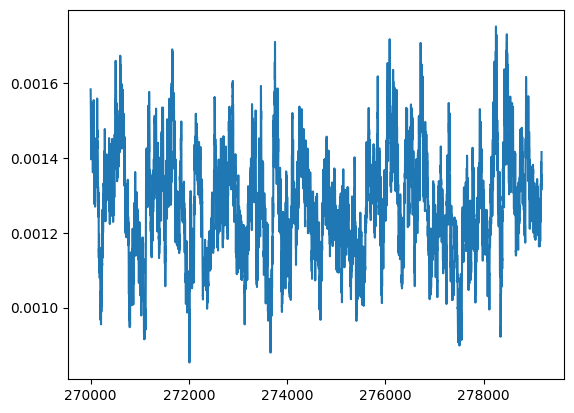

In [108]:
smooth = 1
x = np.arange(len(losses)/smooth)
y = torch.tensor(losses).view(smooth, -1).mean(0)
plt.plot(x[270000:], y[270000:])


In [6]:
def game_sim():
    snake = [(14, 14)]
    dataset = []
    moves = 0
    while True:
        dataset.append(snake.copy())
        while True:
            apple = (int(np.random.rand(1) * board_size), int(np.random.rand(1) * board_size))
            if apple not in snake:
                break
        pathington = BFS(snake[0], apple, snake, 1)
        if len(pathington) == 0:
            return dataset, moves, len(snake)
        path = pathington[0]
        moves += len(path)
        path = path + snake
        snake.append((0, 0))
        for i, piece in enumerate(snake):
            snake[i] = path[i]

In [7]:
def get_neighbors(p, snake, distance):
    reduced = snake.copy()
    for i in range(distance):
        if len(reduced) > 0:
            reduced.remove(reduced[len(reduced) - 1])
    if p[0] + 1 < board_size and (p[0] + 1, p[1]) not in reduced:
        top = (p[0] + 1, p[1])
    else:
        top = None
    if p[0] - 1 > -1 and (p[0] - 1, p[1]) not in reduced:
        bottom = (p[0] - 1, p[1])
    else:
        bottom = None
    if p[1] + 1 < board_size and (p[0], p[1] + 1) not in reduced:
        right = (p[0], p[1] + 1)
    else:
        right = None
    if p[1] - 1 > -1 and (p[0], p[1] - 1) not in reduced:
        left = (p[0], p[1] - 1)
    else:
        left = None
    return top, right, bottom, left

In [8]:
class Node:
    def __init__(self, value, depth, path, h): # depth is inherently g score
        self.value = value
        self.path = path + [value]
        self.depth = depth
        self.h = h
    def __eq__(self, other):
        if self.value == other.value and self.depth == other.depth:
            return True
        else:
            return False

In [9]:
def BFS(start, end, snake, n):
    paths = []
    tree = [Node(start, 0, [], euclidian(start, end))]
    while len(tree) != 0:
        min_val = 1000000
        min_node = None
        for i in tree:
            if i.depth + i.h < min_val:
                min_val = i.depth + i.h
                min_node = i
        current = min_node
        if current.value == end:
            paths.append(list(reversed(current.path)))
        if len(paths) == n:
            return paths
        neighbors = get_neighbors(current.value, snake, current.depth)
        for neighbor in neighbors:
            if neighbor is not None:
                node = Node(neighbor, current.depth + 1, current.path, euclidian(neighbor, end))
                if node not in tree and neighbor not in current.path:
                    tree.append(node)
        tree.remove(current)
    return paths

In [10]:
def euclidian(a, b):
    x = abs(a[0] - b[0])
    y = abs(a[1] - b[1])
    return np.sqrt(x**2 + y**2)